# Tanzania Water Pump Classification Project

There are over 56,000 water pumps in Tanzania and the challenge is to create a model that can accurately classify them into the one of the following:

- Functional
- Non Functional
- Functional needs repair

Why?
- Save on money, time and labor.
- Ensure potable water is being provided to as many communities as possible

It would be much better if the Tanzanian Government was able to focus its time and resources to deliver potable water across all communities in a more efficient manner.
Being able to accurately identify pumps in need of repair or broken pumps would improve efficiency in terms of site visits, labor costs, materials and also be a way of informing communities of where they can find their nearest working pump 

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
import json
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from  sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from imblearn.pipeline import make_pipeline as mp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
path_to_src = '..\src'
sys.path.insert(0, path_to_src)
from useful_functions import *
import pickle

## Data

The data was downloaded directly from the [Driven Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

A summary of the features was provided:
- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

Each water well is labelled as one of the 3 categories:

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

## Data Cleaning

A full walk through of the data cleaning can be found [here](https://github.com/aggie2411/Phase_3_Project/blob/main/Notebooks/data_cleaning_v2.ipynb)

The main takeaways from the data cleaning process was there were several columns with high cardinality, this makes them impractical for processing and one hot encoding. With more time these features could have been binned or categorised in a different way but for now they were dropped. 

There were also several features that contained a lot of zero values - longitude, latitude, population etc. Where applicable these have been replaced by a suitable value but some of the features for example population had such a high number of zero values that maybe it could benefit from a more rigorous imputation. The zero values based on averages for respective regions, wards, subvillages district code.

The final features used in the modelling was:




- longitude - GPS coordinate
- latitude - GPS coordinate
- basin - Geographic water basin
- region - Geographic location
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint


For validation purposes, I have split the data at the cleaning stage, all imputation was done using values held within each data set to avoid data leakage. 

Since this project is also part of a competition I will also import the competition data so it can be run and predictions can be submitted

Final Data Summary:

- Training Data
- Validation Data
- Competition Data


## EDA

Images taken from [this](https://github.com/aggie2411/Phase_3_Project/blob/main/Notebooks/data_cleaning_v2.ipynb) notebook.

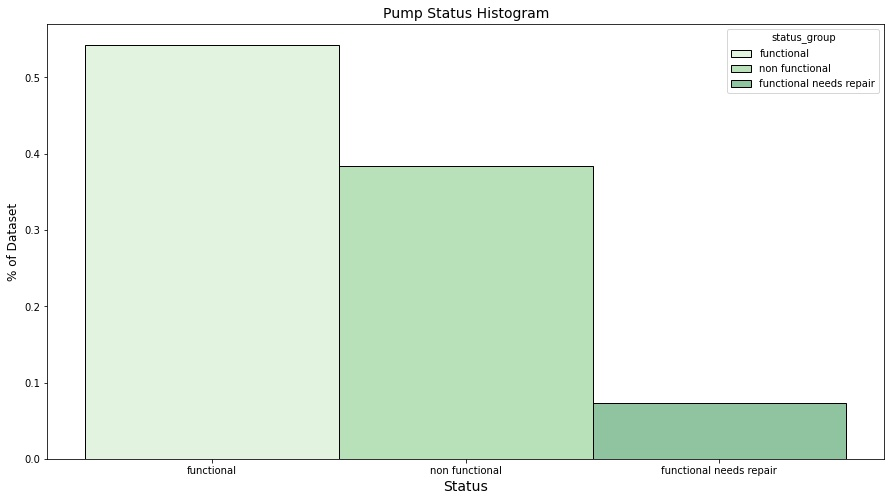

It is clear from the histogram that this data set suffers from class imbalance, depending on how the government would want to prioritise repairs, this project could easily have focused on one category over the other in terms of performance and selected the best model for a given class. However as the competition metric used is accuracy, this is the one I will be using.

#### Location matters

It looks like when plotting the status of the pumps on the maps there are some patterns emerging, particularly in the South East. Location is likely to be an important feature any model. In this plot, the bigger the marker size, the bigger the population. An interactive version of this map is found in the notebook link above. 

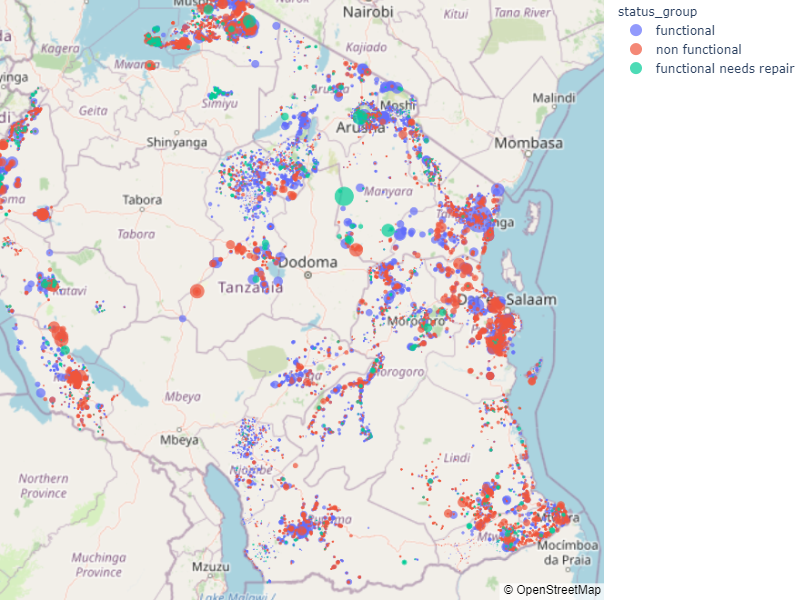

The above map is confirmed by the chart below. It clearly shows the distribution of functional pumps is not equal, some regions have only 30% of pumps functioning where as the best performing region has > 70%.

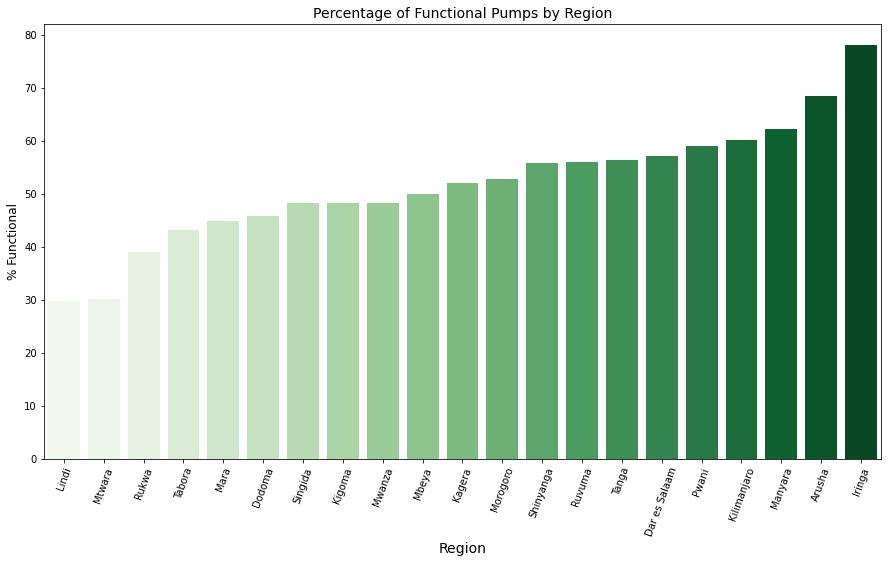

That is not the only feature where there seems to be a strong relationship, the quantity of water also plays a role. this could be mis-classification it is unclear. From a realistic stand point, a dry well isn't functioning, but does that also mean the well wouldn't work if water returned. This is slightly ambiguous but could result in many pumps being incorrectly classified as non functioning.

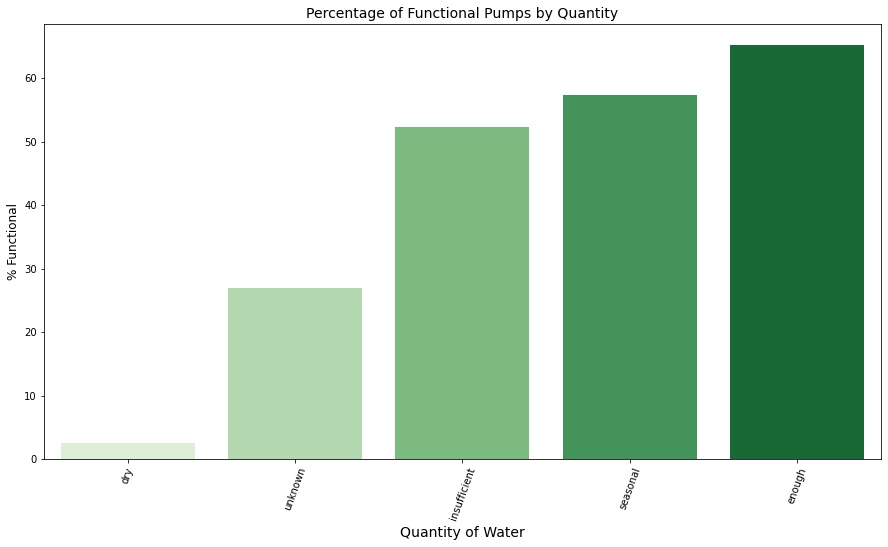

## Import Data

I will import the three different data sets, created during the data cleaning stage.

In [2]:
df = pd.read_csv('../data/train.csv')
validate = pd.read_csv('../data/validate.csv')

df.head()

,longitude,latitude,basin,region,district_code,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,pop_log,age,status_group
0,34.94,-9.86,Lake Nyasa,Iringa,DD5,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,4.691348,12,functional
1,34.70,-2.15,Lake Victoria,Mara,DD2,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,5.634790,3,functional
2,37.46,-3.82,Pangani,Manyara,DD4,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,5.521461,4,functional
3,38.49,-11.16,Ruvuma / Southern Coast,Mtwara,DD63,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,4.060443,27,non functional
4,31.13,-1.83,Lake Victoria,Kagera,DD1,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,6.092055,14,functional


## Split the Data

Although the data is already split, I will still continue to create a train test split, the validation data will only be introduced right at the end of the modelling phase for each type of model

In [3]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model

The workflow for the baseline model can be found [here](https://github.com/aggie2411/Phase_3_Project/blob/main/Notebooks/Baseline_Model.ipynb). For the purposes of this summary I will import the model via Pickle. The code for the pipeline will be displayed in markdown.

### Create Pipeline

Creating a pipeline that will have a StandardScaler() and also a OneHotEncoder() transformers built, the pipeline will vary for each model but the preprocessing element will remain constant.

``` python
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
full_pipeline = make_pipeline(preprocessing, LogisticRegression(solver='saga', 
                            random_state=42, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1))
```

### Load Baseline Model

In [4]:
file = open('../models/baseline.pkl', 'rb')
baseline = pickle.load(file)
file.close()

### Get Predictions

In [5]:
y_hat_baseline_train = baseline.predict(X_train)
y_hat_baseline_test = baseline.predict(X_test)

### Classification Reports

##### Train

In [6]:
print(classification_report(y_train, y_hat_baseline_train))

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80     16207
functional needs repair       0.49      0.04      0.07      2193
         non functional       0.79      0.65      0.72     11600

               accuracy                           0.74     30000
              macro avg       0.67      0.53      0.53     30000
           weighted avg       0.73      0.74      0.71     30000



##### Test

In [7]:
print(classification_report(y_test, y_hat_baseline_test))

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80      5427
functional needs repair       0.65      0.04      0.08       754
         non functional       0.78      0.65      0.71      3819

               accuracy                           0.74     10000
              macro avg       0.72      0.53      0.53     10000
           weighted avg       0.74      0.74      0.71     10000



### Confusion Matrix

##### Train

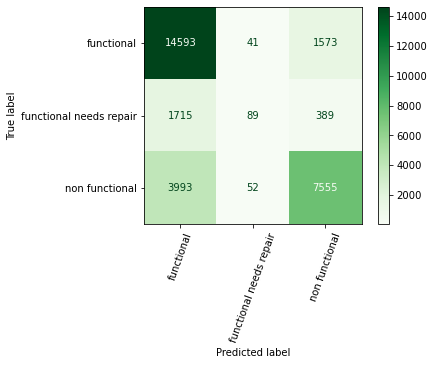

In [8]:
plot_confusion_matrix(baseline, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

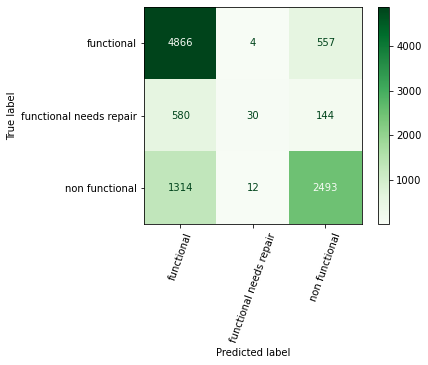

In [9]:
plot_confusion_matrix(baseline, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show() 

### Validation

I will check the scores using cross_val_score but I will also run cross_val_score on the validation data set

##### Train Cross_Val_Score

In [10]:
baseline_score = cross_val_score(baseline, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', baseline_score.round(5))

5 fold cross-validation score: 0.73847


##### Checking Model on Validation Data

In [11]:
baseline_val_preds = baseline.predict(validate.drop(['status_group'], axis=1))

In [12]:
baseline_accuracy = accuracy_score(validate['status_group'],baseline_val_preds)
print("Accuracy on validation data is: %.2f%%" % (baseline_accuracy * 100.0))

Accuracy on validation data is: 73.84%


### Baseline Summary

The model accuracy is good (0.74 for both the train and test set) but this can be a deceptive metric, the precision and recall for 'functional needs repair' is poor, this is a class that we want to reduce the number of false negatives, if this is improved that means the pumps in need of repair can be fixed before they breakdown altogether. The poor score in the functional needs repair class could be due to the imbalance in the dataset - there are relatively few instances of this class compared to the other two.

Considering the competition where this dataset comes from uses accuracy as the metric, this will also be the metric used for evaluation here. Recall however will be considered for models that are closely matching in accuracy.

In [13]:
# Define table as a dataframe with specific columns. Each column's values will be a list that we will add to.
summary = pd.DataFrame({'Model': [], 'Train Accuracy':[], 'Test Accuracy' : [], 'Validation Accuracy':[],
                                'Train Recall':[], 'Test Recall':[]})

# Add data for simple linear regression
summary.loc[0] = ['Baseline Logistic Regression', accuracy_score(y_train, y_hat_baseline_train),\
                  accuracy_score(y_test,y_hat_baseline_test), baseline_accuracy,\
                  recall_score(y_train, y_hat_baseline_train, average='weighted'), recall_score(y_test,y_hat_baseline_test,\
                                                                                              average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389


## Baseline with SMOTE

### Create Pipeline

``` python
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')

preprocessing2 = mp(preprocessing, SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'))


logregsmote = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), LogisticRegression(solver='saga', 
                            random_state=42, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1), )
```



### Load Model

In [14]:
file = open('../models/baselinesmote.pkl', 'rb')
baselinesmote = pickle.load(file)
file.close()

### Get Predictions

In [15]:
y_hat_baselinesmote_train = baselinesmote.predict(X_train)
y_hat_baselinesmote_test = baselinesmote.predict(X_test)

### Classification Reports

##### Train

In [16]:
print(classification_report(y_train, y_hat_baselinesmote_train))

                         precision    recall  f1-score   support

             functional       0.79      0.63      0.70     16207
functional needs repair       0.20      0.67      0.30      2193
         non functional       0.78      0.64      0.70     11600

               accuracy                           0.64     30000
              macro avg       0.59      0.65      0.57     30000
           weighted avg       0.74      0.64      0.67     30000



##### Test

In [17]:
print(classification_report(y_test, y_hat_baselinesmote_test))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      5427
functional needs repair       0.20      0.65      0.31       754
         non functional       0.77      0.65      0.70      3819

               accuracy                           0.64     10000
              macro avg       0.59      0.64      0.57     10000
           weighted avg       0.74      0.64      0.67     10000



Note the increase in performance in the minority class recall score

### Confusion Matrix

##### Train

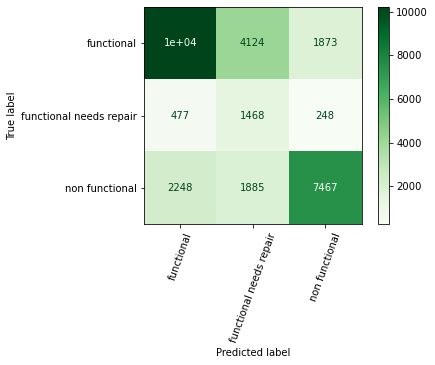

In [18]:
plot_confusion_matrix(baselinesmote, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

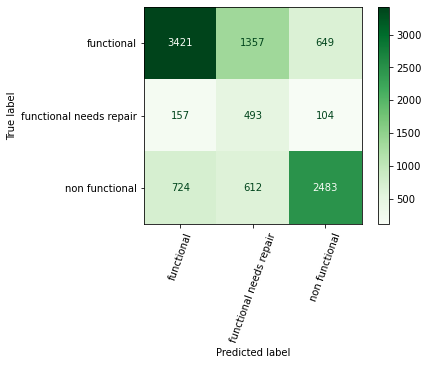

In [19]:
plot_confusion_matrix(baselinesmote, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [20]:
baselinesmote_score = cross_val_score(baselinesmote, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', baselinesmote_score.round(5))

5 fold cross-validation score: 0.63517


##### Checking Model Score on Validation Data

In [21]:
baselinesmote_val_preds = baselinesmote.predict(validate.drop(['status_group'], axis=1))

In [22]:
baselinesmote_accuracy = accuracy_score(validate['status_group'],baselinesmote_val_preds)
print("Accuracy on validation data is: %.2f%%" % (baselinesmote_accuracy * 100.0))

Accuracy on validation data is: 60.96%


### Baseline with SMOTE Summary

The recall score has vastly improved for the minority class as a result of implementing SMOTE.
However the overall performance of the model has decreased.

Positives from this model however are there is still no sign of overfitting, performance on training/test data is similar to the validation data set.

In [23]:
# Add data for simple linear regression
summary.loc[1] = ['Baseline Logistic Regression with SMOTE', accuracy_score(y_train, y_hat_baselinesmote_train),\
                  accuracy_score(y_test,y_hat_baselinesmote_test), baselinesmote_accuracy,\
                  recall_score(y_train, y_hat_baselinesmote_train, average='weighted'),\
                  recall_score(y_test,y_hat_baselinesmote_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397


## Decision Tree

### Create Pipeline

``` python
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
dt_pipeline = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   DecisionTreeClassifier(random_state=42))
```



### Load Model

In [24]:
file = open('../models/dtsmote.pkl', 'rb')
dtsmote = pickle.load(file)
file.close()

### Get Predictions

In [25]:
y_hat_dtsmote_train = dtsmote.predict(X_train)
y_hat_dtsmote_test = dtsmote.predict(X_test)

### Classification Reports

##### Train

In [26]:
print(classification_report(y_train, y_hat_dtsmote_train))

                         precision    recall  f1-score   support

             functional       0.98      1.00      0.99     16207
functional needs repair       0.96      0.95      0.95      2193
         non functional       1.00      0.98      0.99     11600

               accuracy                           0.99     30000
              macro avg       0.98      0.97      0.98     30000
           weighted avg       0.99      0.99      0.99     30000



##### Test

In [27]:
print(classification_report(y_test, y_hat_dtsmote_test))

                         precision    recall  f1-score   support

             functional       0.79      0.77      0.78      5427
functional needs repair       0.34      0.38      0.36       754
         non functional       0.75      0.76      0.75      3819

               accuracy                           0.74     10000
              macro avg       0.63      0.64      0.63     10000
           weighted avg       0.74      0.74      0.74     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

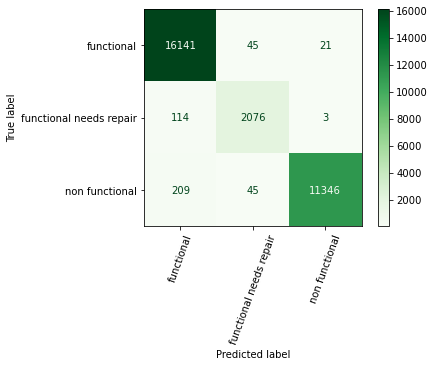

In [28]:
plot_confusion_matrix(dtsmote, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

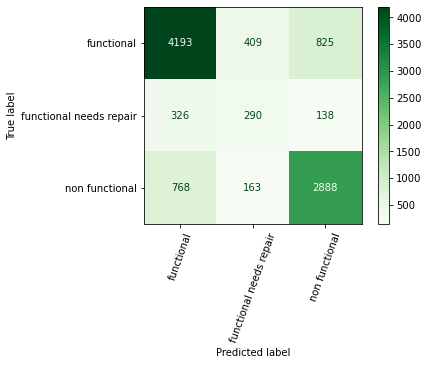

In [29]:
plot_confusion_matrix(dtsmote, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [30]:
dtsmote_score = cross_val_score(dtsmote, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', dtsmote_score.round(5))

5 fold cross-validation score: 0.7355


##### Checking Model Score on Validation Data

In [31]:
dtsmote_val_preds = dtsmote.predict(validate.drop(['status_group'], axis=1))

In [32]:
dtsmote_accuracy = accuracy_score(validate['status_group'],dtsmote_val_preds)
print("Accuracy on validation data is: %.2f%%" % (dtsmote_accuracy * 100.0))

Accuracy on validation data is: 68.11%


### Decision Tree Summary

The baseline decision tree performs well but is overfitting on training data, despite this the results on the validation data set are better than the baseline logreg model with SMOTE. The recall score is also better, minimising false negatives in the minority class

In [33]:
# Add data for simple linear regression
summary.loc[2] = ['Decision Tree with SMOTE', accuracy_score(y_train, y_hat_dtsmote_train),\
                  accuracy_score(y_test,y_hat_dtsmote_test), dtsmote_accuracy,\
                  recall_score(y_train, y_hat_dtsmote_train, average='weighted'),\
                  recall_score(y_test,y_hat_dtsmote_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371


I did attempt to tune the decision tree, full details can be found [here](https://github.com/aggie2411/Phase_3_Project/blob/main/Notebooks/Decision%20Tree.ipynb), it wasn't successful but in this summary I will just load the model and results to the summary table.

## Decision Tree Tuned

### Create Pipeline

``` python
dt_optimal = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   DecisionTreeClassifier(max_features=30, min_samples_leaf=1,\
                                          min_samples_split=0.8,max_depth=20,random_state=42))
```



### Load Model

In [34]:
file = open('../models/tuneddt.pkl', 'rb')
tuneddt = pickle.load(file)
file.close()

### Get Predictions

In [35]:
y_hat_tuneddt_train = tuneddt.predict(X_train)
y_hat_tuneddt_test = tuneddt.predict(X_test)

### Classification Reports

##### Train

In [36]:
print(classification_report(y_train, y_hat_tuneddt_train))

                         precision    recall  f1-score   support

             functional       0.86      0.13      0.22     16207
functional needs repair       0.09      0.91      0.17      2193
         non functional       0.87      0.43      0.57     11600

               accuracy                           0.30     30000
              macro avg       0.61      0.49      0.32     30000
           weighted avg       0.81      0.30      0.35     30000



##### Test

In [37]:
print(classification_report(y_test, y_hat_tuneddt_test))

                         precision    recall  f1-score   support

             functional       0.88      0.13      0.22      5427
functional needs repair       0.10      0.93      0.17       754
         non functional       0.87      0.42      0.57      3819

               accuracy                           0.30     10000
              macro avg       0.62      0.49      0.32     10000
           weighted avg       0.82      0.30      0.35     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

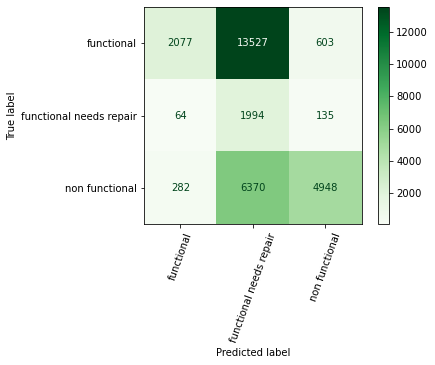

In [38]:
plot_confusion_matrix(tuneddt, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

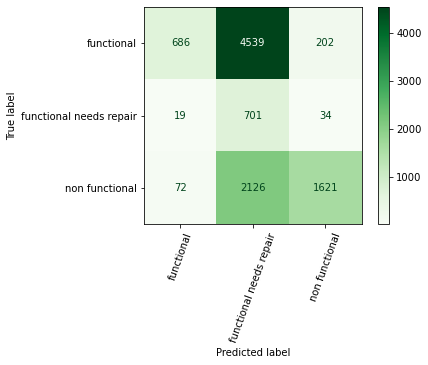

In [39]:
plot_confusion_matrix(tuneddt, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [40]:
tuneddt_score = cross_val_score(tuneddt, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', tuneddt_score.round(5))

5 fold cross-validation score: 0.52807


##### Checking Model Score on Validation Data

In [41]:
tuneddt_val_preds = tuneddt.predict(validate.drop(['status_group'], axis=1))

In [42]:
tuneddt_accuracy = accuracy_score(validate['status_group'],tuneddt_val_preds)
print("Accuracy on validation data is: %.2f%%" % (tuneddt_accuracy * 100.0))

Accuracy on validation data is: 30.14%


In [43]:
summary.loc[3] = ['Decision Tree tuned', accuracy_score(y_train, y_hat_tuneddt_train),\
                  accuracy_score(y_test,y_hat_tuneddt_test), tuneddt_accuracy,\
                  recall_score(y_train, y_hat_tuneddt_train, average='weighted'),\
                  recall_score(y_test,y_hat_tuneddt_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008


### Summary Tuned Decision Tree

Although the overfitting disappeared, the tuned model performed terribly, this is likely a result of the method in which I tuned the parameters - one by one. It is always possible to not choose the optimum range of parameters to explore, then selecting the best performing hyperparameter one at a time has its flaws. 

## K-Nearest Neighbors

### Create Pipeline

``` python
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
knn_pipeline = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   KNeighborsClassifier())
```



### Load Model

In [44]:
file = open('../models/knnsmote.pkl', 'rb')
knnsmote = pickle.load(file)
file.close()

### Get Predictions

In [45]:
y_hat_knnsmote_train = knnsmote.predict(X_train)
y_hat_knnsmote_test = knnsmote.predict(X_test)

### Classification Reports

##### Train

In [46]:
print(classification_report(y_train, y_hat_knnsmote_train))

                         precision    recall  f1-score   support

             functional       0.89      0.81      0.85     16207
functional needs repair       0.47      0.91      0.62      2193
         non functional       0.86      0.82      0.84     11600

               accuracy                           0.82     30000
              macro avg       0.74      0.85      0.77     30000
           weighted avg       0.85      0.82      0.83     30000



##### Test

In [47]:
print(classification_report(y_test, y_hat_knnsmote_test))

                         precision    recall  f1-score   support

             functional       0.81      0.73      0.77      5427
functional needs repair       0.28      0.57      0.38       754
         non functional       0.77      0.72      0.74      3819

               accuracy                           0.71     10000
              macro avg       0.62      0.67      0.63     10000
           weighted avg       0.75      0.71      0.73     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

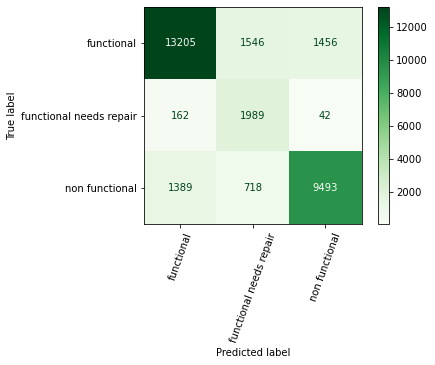

In [48]:
plot_confusion_matrix(knnsmote, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

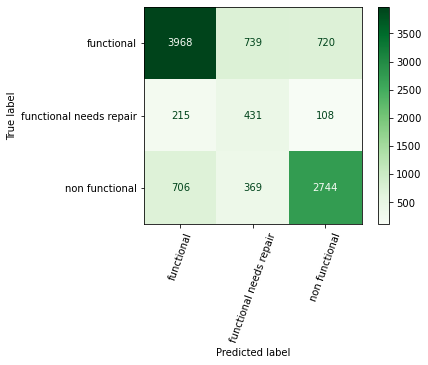

In [49]:
plot_confusion_matrix(knnsmote, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [50]:
knnsmote_score = cross_val_score(knnsmote, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', knnsmote_score.round(5))

5 fold cross-validation score: 0.7081


##### Checking Model Score on Validation Data

In [51]:
knnsmote_val_preds = knnsmote.predict(validate.drop(['status_group'], axis=1))

In [52]:
knnsmote_accuracy = accuracy_score(validate['status_group'],knnsmote_val_preds)
print("Accuracy on validation data is: %.2f%%" % (knnsmote_accuracy * 100.0))

Accuracy on validation data is: 67.23%


### KNN Summary

The KNN model is the best so far, it also has good performance in recall in the minority class. There is a drop off in performance however between test and train data indicating some overfitting. The performance drops off even further in the validation data set.

In [53]:
# Add data for simple linear regression
summary.loc[4] = ['KNN SMOTE', accuracy_score(y_train, y_hat_knnsmote_train),\
                  accuracy_score(y_test,y_hat_knnsmote_test), knnsmote_accuracy,\
                  recall_score(y_train, y_hat_knnsmote_train, average='weighted'),\
                  recall_score(y_test,y_hat_knnsmote_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143


## Random Forest Baseline

### Create Pipeline

``` python
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
rf_pipeline = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   RandomForestClassifier(n_jobs=-1, random_state=42))
```



### Load Model

In [54]:
file = open('../models/rfbase.pkl', 'rb')
rfbase = pickle.load(file)
file.close()

### Get Predictions

In [55]:
y_hat_rfbase_train = rfbase.predict(X_train)
y_hat_rfbase_test = rfbase.predict(X_test)

### Classification Reports

##### Train

In [56]:
print(classification_report(y_train, y_hat_rfbase_train))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     16207
functional needs repair       0.94      0.96      0.95      2193
         non functional       0.99      0.98      0.99     11600

               accuracy                           0.99     30000
              macro avg       0.97      0.98      0.98     30000
           weighted avg       0.99      0.99      0.99     30000



##### Test

In [57]:
print(classification_report(y_test, y_hat_rfbase_test))

                         precision    recall  f1-score   support

             functional       0.81      0.83      0.82      5427
functional needs repair       0.42      0.40      0.41       754
         non functional       0.80      0.78      0.79      3819

               accuracy                           0.78     10000
              macro avg       0.68      0.67      0.67     10000
           weighted avg       0.78      0.78      0.78     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

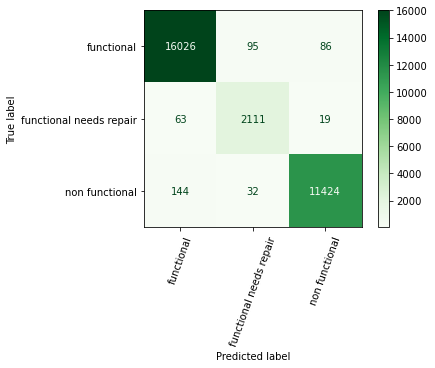

In [58]:
plot_confusion_matrix(rfbase, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

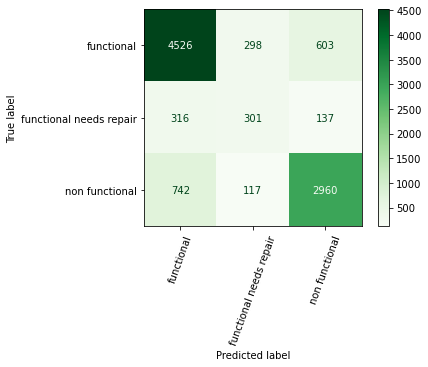

In [59]:
plot_confusion_matrix(rfbase, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [60]:
rfbase_score = cross_val_score(rfbase, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', rfbase_score.round(5))

5 fold cross-validation score: 0.77623


##### Checking Model Score on Validation Data

In [61]:
rfbase_val_preds = rfbase.predict(validate.drop(['status_group'], axis=1))

In [62]:
rfbase_accuracy = accuracy_score(validate['status_group'],rfbase_val_preds)
print("Accuracy on validation data is: %.2f%%" % (rfbase_accuracy * 100.0))

Accuracy on validation data is: 77.30%


### Random Forest Summary

The KNN model is the best so far, it also has good performance in recall in the minority class. There is a drop off in performance however between test and train data indicating some overfitting. The performance drops off even further in the validation data set.

In [63]:
# Add data for simple linear regression
summary.loc[5] = ['Random Forest Base', accuracy_score(y_train, y_hat_rfbase_train),\
                  accuracy_score(y_test,y_hat_rfbase_test), rfbase_accuracy,\
                  recall_score(y_train, y_hat_rfbase_train, average='weighted'),\
                  recall_score(y_test,y_hat_rfbase_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143
5,Random Forest Base,0.985367,0.7787,0.773030,0.985367,0.7787


## Random Forest Tuned

Keeping the tuning process out of this notebook to save time whilst running. I utilised RandomizedsearchCV to find the optimum hyperparamters in an attempt to remove the overfitting

### Tuning Set Up

``` python
pipe = Pipeline(steps=[('preprocessor', preprocessing),
                         ('sampling', SMOTE(random_state=42, n_jobs=-1, sampling_strategy='minority')),
                        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
                        ])
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = np.array(range(1, X_train.shape[1]+1, 1))

max_depth = [int(x) for x in np.linspace(20, 45, num = 6)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [2, 4, 6]


# Create the random grid
parameters = [{'classifier__n_estimators': n_estimators,
              'classifier__max_features': max_features,
              'classifier__max_depth': max_depth,
              'classifier__min_samples_split': min_samples_split,
              'classifier__min_samples_leaf': min_samples_leaf}]

scorers = {
    'recall_score': make_scorer(recall_score, average='weighted')
     , 'accuracy_score': make_scorer(accuracy_score)
}

gridsearch = RandomizedSearchCV(pipe, parameters, cv=5, random_state=42, 
                                scoring=scorers, n_jobs=-1, refit='accuracy_score',
                               n_iter=10)
gridsearch_rf = gridsearch.fit(X_train, y_train)
```

Getting the best estimators I used the following pipeline as a tuned model:

### Create Pipeline

``` python
rf_pipeline2 = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=4,\
                                          max_features=13, max_depth=45, n_jobs=-1, random_state=42))
```



### Load Model

In [64]:
file = open('../models/rftuned.pkl', 'rb')
rftuned = pickle.load(file)
file.close()

### Get Predictions

In [65]:
y_hat_rftuned_train = rftuned.predict(X_train)
y_hat_rftuned_test = rftuned.predict(X_test)

### Classification Reports

##### Train

In [66]:
print(classification_report(y_train, y_hat_rftuned_train))

                         precision    recall  f1-score   support

             functional       0.88      0.87      0.87     16207
functional needs repair       0.50      0.78      0.61      2193
         non functional       0.90      0.82      0.86     11600

               accuracy                           0.84     30000
              macro avg       0.76      0.82      0.78     30000
           weighted avg       0.86      0.84      0.85     30000



##### Test

In [67]:
print(classification_report(y_test, y_hat_rftuned_test))

                         precision    recall  f1-score   support

             functional       0.82      0.81      0.81      5427
functional needs repair       0.35      0.52      0.42       754
         non functional       0.82      0.75      0.78      3819

               accuracy                           0.77     10000
              macro avg       0.66      0.69      0.67     10000
           weighted avg       0.78      0.77      0.77     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

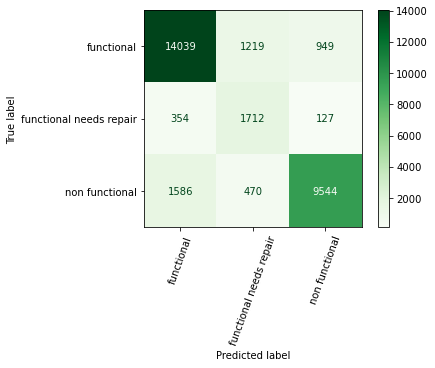

In [68]:
plot_confusion_matrix(rftuned, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

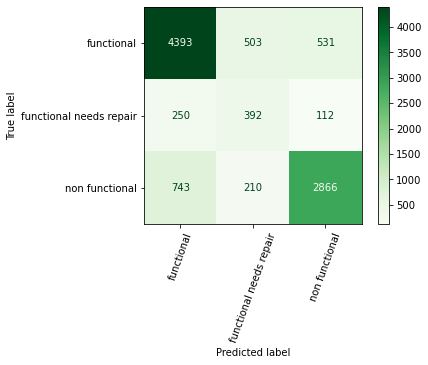

In [69]:
plot_confusion_matrix(rftuned, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [70]:
rftuned_score = cross_val_score(rftuned, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', rftuned_score.round(5))

5 fold cross-validation score: 0.7626


##### Checking Model Score on Validation Data

In [71]:
rftuned_val_preds = rftuned.predict(validate.drop(['status_group'], axis=1))

In [72]:
rftuned_accuracy = accuracy_score(validate['status_group'],rftuned_val_preds)
print("Accuracy on validation data is: %.2f%%" % (rftuned_accuracy * 100.0))

Accuracy on validation data is: 75.84%


### Random Forest Tuned Summary

There is a slight drop off in performance with the tuned model, however the overfitting has been dramatically improved, the training set accuracy is no longer ~1 and much closer to the test and validation data. As with decision tree tuning, I could expand the parameters of the randomizedsearchCV further to try and improve this.

In [73]:
# Add data for simple linear regression
summary.loc[6] = ['Random Forest Tuned', accuracy_score(y_train, y_hat_rftuned_train),\
                  accuracy_score(y_test,y_hat_rftuned_test), rftuned_accuracy,\
                  recall_score(y_train, y_hat_rftuned_train, average='weighted'),\
                  recall_score(y_test,y_hat_rftuned_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143
5,Random Forest Base,0.985367,0.7787,0.773030,0.985367,0.7787
6,Random Forest Tuned,0.843167,0.7651,0.758390,0.843167,0.7651


## XGBoost Baseline

### Create Pipeline

``` python
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
rf_pipeline = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   RandomForestClassifier(n_jobs=-1, random_state=42))
```



### Load Model

In [74]:
file = open('../models/xgbbase.pkl', 'rb')
xgbbase = pickle.load(file)
file.close()

### Get Predictions

In [75]:
y_hat_xgbbase_train = xgbbase.predict(X_train)
y_hat_xgbbase_test = xgbbase.predict(X_test)

### Classification Reports

##### Train

In [76]:
print(classification_report(y_train, y_hat_xgbbase_train))

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83     16207
functional needs repair       0.43      0.61      0.50      2193
         non functional       0.86      0.76      0.81     11600

               accuracy                           0.79     30000
              macro avg       0.70      0.74      0.71     30000
           weighted avg       0.81      0.79      0.80     30000



##### Test

In [77]:
print(classification_report(y_test, y_hat_xgbbase_test))

                         precision    recall  f1-score   support

             functional       0.79      0.81      0.80      5427
functional needs repair       0.36      0.48      0.42       754
         non functional       0.81      0.73      0.76      3819

               accuracy                           0.75     10000
              macro avg       0.65      0.67      0.66     10000
           weighted avg       0.77      0.75      0.76     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

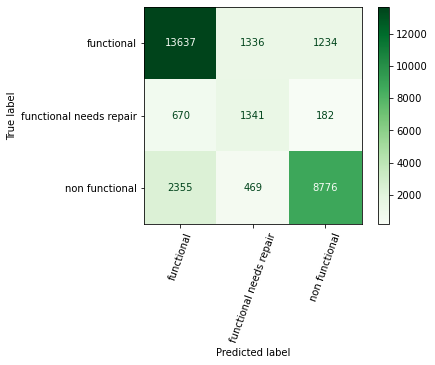

In [78]:
plot_confusion_matrix(xgbbase, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

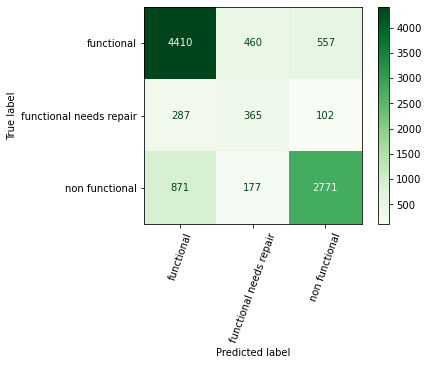

In [79]:
plot_confusion_matrix(xgbbase, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [80]:
xgbbase_score = cross_val_score(xgbbase, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', xgbbase_score.round(5))

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:08:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:08:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:08:49] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:09:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:09:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5 fold cross-validation score: 0.757


##### Checking Model Score on Validation Data

In [81]:
xgbbase_val_preds = xgbbase.predict(validate.drop(['status_group'], axis=1))

In [82]:
xgbbase_accuracy = accuracy_score(validate['status_group'],xgbbase_val_preds)
print("Accuracy on validation data is: %.2f%%" % (xgbbase_accuracy * 100.0))

Accuracy on validation data is: 74.46%


### XGBoost Summary

The KNN model is the best so far, it also has good performance in recall in the minority class. There is a drop off in performance however between test and train data indicating some overfitting. The performance drops off even further in the validation data set.

In [83]:
# Add data for simple linear regression
summary.loc[7] = ['XGBoost Base', accuracy_score(y_train, y_hat_xgbbase_train),\
                  accuracy_score(y_test,y_hat_xgbbase_test), xgbbase_accuracy,\
                  recall_score(y_train, y_hat_xgbbase_train, average='weighted'),\
                  recall_score(y_test,y_hat_xgbbase_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143
5,Random Forest Base,0.985367,0.7787,0.773030,0.985367,0.7787
6,Random Forest Tuned,0.843167,0.7651,0.758390,0.843167,0.7651
7,XGBoost Base,0.791800,0.7546,0.744574,0.791800,0.7546


## XGBoost Tuned

Keeping the tuning process out of this notebook to save time whilst running. I utilised RandomizedsearchCV to find the optimum hyperparamters in an attempt to remove the overfitting

### Tuning Set Up

``` python
pipe = Pipeline(steps=[('preprocessor', preprocessing),
                         ('sampling', SMOTE(random_state=42, n_jobs=-1, sampling_strategy='minority')),
                        ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
                        ])
# Create the random grid
n_estimators=[50, 100, 500, 1000]
max_depth=[5, 10, 15, 20]
learning_rate=[0.1, 0.3, 0.5]
booster = ['gbtree', 'dart']

parameters = [{'classifier__n_estimators': n_estimators,
              'classifier__max_depth': max_depth,
              'classifier__learning_rate': learning_rate,
              'classifier__booster': booster}]

scorers = {
    'recall_score': make_scorer(recall_score, average='weighted')
     , 'accuracy_score': make_scorer(accuracy_score)
}

xgb_randomized = RandomizedSearchCV(pipe, parameters, cv=5, random_state=42, 
                                scoring=scorers, n_jobs=-1, refit='accuracy_score',
                               n_iter=10)
```

Getting the best estimators I used the following pipeline as a tuned model:

### Create Pipeline

``` python
xgb_pipeline2 = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   XGBClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=15, learning_rate=0.3,\
                                booster='dart'))
```



### Load Model

In [84]:
file = open('../models/xgbtuned.pkl', 'rb')
xgbtuned = pickle.load(file)
file.close()

### Get Predictions

In [85]:
y_hat_xgbtuned_train = xgbtuned.predict(X_train)
y_hat_xgbtuned_test = xgbtuned.predict(X_test)

### Classification Reports

##### Train

In [86]:
print(classification_report(y_train, y_hat_xgbtuned_train))

                         precision    recall  f1-score   support

             functional       0.96      0.98      0.97     16207
functional needs repair       0.89      0.91      0.90      2193
         non functional       0.98      0.96      0.97     11600

               accuracy                           0.96     30000
              macro avg       0.94      0.95      0.95     30000
           weighted avg       0.96      0.96      0.96     30000



##### Test

In [87]:
print(classification_report(y_test, y_hat_xgbtuned_test))

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      5427
functional needs repair       0.46      0.40      0.43       754
         non functional       0.81      0.78      0.79      3819

               accuracy                           0.79     10000
              macro avg       0.69      0.68      0.68     10000
           weighted avg       0.78      0.79      0.79     10000



Performing well, there has been a drop in minority class recall and there is clear evidence of overfitting to training data

### Confusion Matrix

##### Train

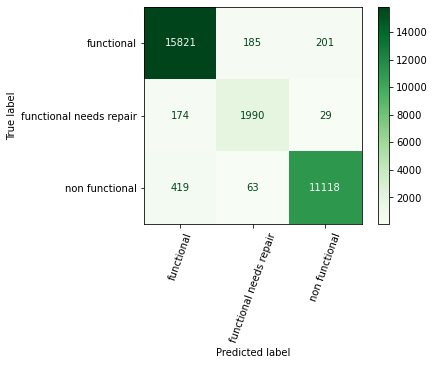

In [88]:
plot_confusion_matrix(xgbtuned, X_train, y_train, xticks_rotation=70, cmap='Greens')  
plt.show() 

##### Test

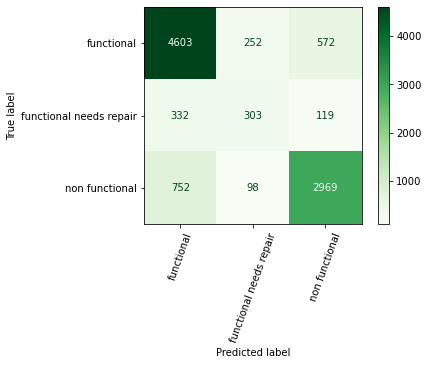

In [89]:
plot_confusion_matrix(xgbtuned, X_test, y_test, xticks_rotation=70, cmap='Greens')  
plt.show()

### Validation 

Checking the scores on the validation data set

##### Train Cross_Val_Score

In [90]:
xgbtuned_score = cross_val_score(xgbtuned, X_train, y_train, scoring='accuracy').mean()
print('5 fold cross-validation score:', xgbtuned_score.round(5))

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:10:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:11:37] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:13:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:14:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:16:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5 fold cross-validation score: 0.78553


##### Checking Model Score on Validation Data

In [91]:
xgbtuned_val_preds = xgbtuned.predict(validate.drop(['status_group'], axis=1))

In [92]:
xgbtuned_accuracy = accuracy_score(validate['status_group'],xgbtuned_val_preds)
print("Accuracy on validation data is: %.2f%%" % (xgbtuned_accuracy * 100.0))

Accuracy on validation data is: 77.48%


### XGBoost Tuned Summary

This is the best performing model so far and even performs well on the validation data. There are still some indications of overfitting but this is the model I will carry forward into the competition

In [93]:
# Add data for simple linear regression
summary.loc[8] = ['XGBoost Tuned', accuracy_score(y_train, y_hat_xgbtuned_train),\
                  accuracy_score(y_test,y_hat_xgbtuned_test), xgbtuned_accuracy,\
                  recall_score(y_train, y_hat_xgbtuned_train, average='weighted'),\
                  recall_score(y_test,y_hat_xgbtuned_test, average='weighted')]

summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143
5,Random Forest Base,0.985367,0.7787,0.773030,0.985367,0.7787
6,Random Forest Tuned,0.843167,0.7651,0.758390,0.843167,0.7651
7,XGBoost Base,0.791800,0.7546,0.744574,0.791800,0.7546
8,XGBoost Tuned,0.964300,0.7875,0.774782,0.964300,0.7875


#### Competition Entry

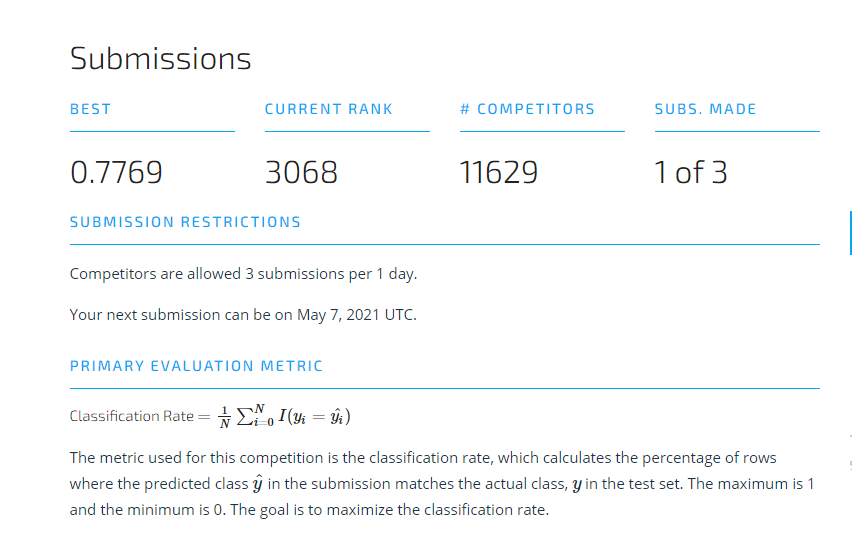

Accuracy score of 0.7769 on the blind data, not bad but room for improvement certainly.

### Feature Importance

Checking the feature importance is an important step in the post processing phase, it may highlight some models that have an over reliance on certain features. These features then in turn could warrant further investigation

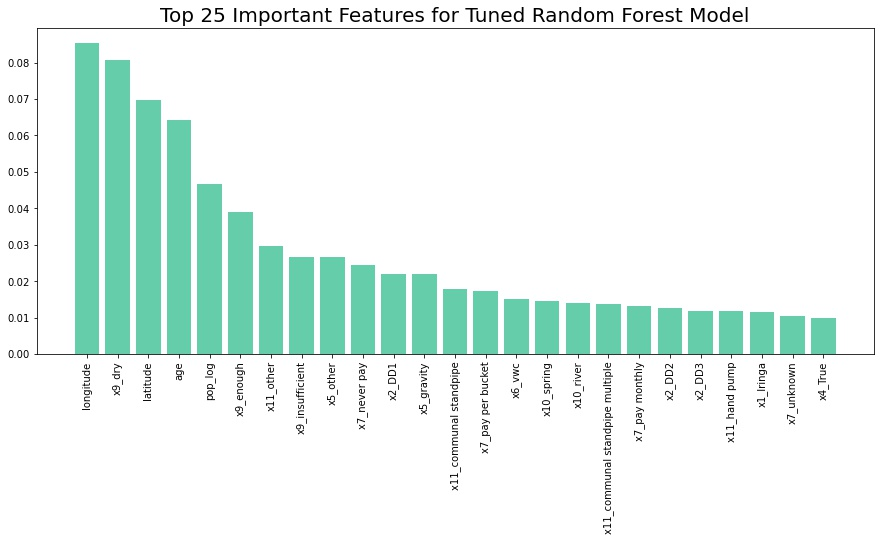

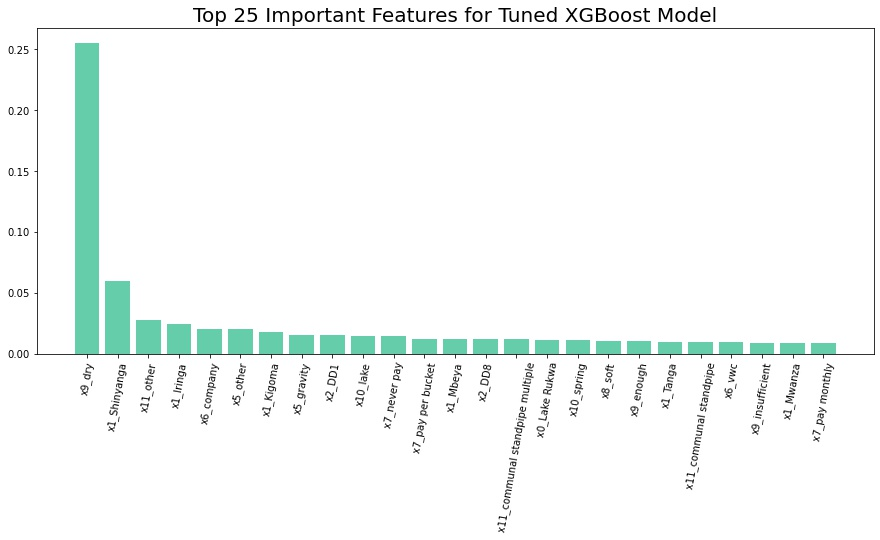

It's interesting to compare the feature importance between two models. The important features in the random forest model certainly appear to be more intuitive i.e they are things that one might expect to influence the status of a pump. The XGBoost model however seems to be very reliant on the X9_Dry parameter which is a onehotencoded feature belonging to the "Quantity" category. 

As we saw earlier, very few pumps in this category are actually functional. This is therefore an area worth further investigation

## Conclusion

- It is recommended to proceed with the tune XGBoost model, this achieved an accuracy score of 0.7747 on the validation data set.
- The recall values for this model were 85,40,78 for the three categories 'functional', 'functional needs repair' and 'non functional'
- this clearly means some pumps in need of repair will be getting missclassified however since the score is poorest in the minority class of which there is relatively few entries, it is not going to be too damaging in terms of wasted resources / site visits etc.
- The X9_Dry feature needs to be investigated, if a well is dry does this mean it automatically non functional?

In [94]:
summary

,Model,Train Accuracy,Test Accuracy,Validation Accuracy,Train Recall,Test Recall
0,Baseline Logistic Regression,0.741233,0.7389,0.738389,0.741233,0.7389
1,Baseline Logistic Regression with SMOTE,0.638167,0.6397,0.609568,0.638167,0.6397
2,Decision Tree with SMOTE,0.985433,0.7371,0.681066,0.985433,0.7371
3,Decision Tree tuned,0.300633,0.3008,0.301407,0.300633,0.3008
4,KNN SMOTE,0.822900,0.7143,0.672303,0.822900,0.7143
5,Random Forest Base,0.985367,0.7787,0.773030,0.985367,0.7787
6,Random Forest Tuned,0.843167,0.7651,0.758390,0.843167,0.7651
7,XGBoost Base,0.791800,0.7546,0.744574,0.791800,0.7546
8,XGBoost Tuned,0.964300,0.7875,0.774782,0.964300,0.7875


## Recommendations & Further Work

 - Use the model in conjunction with EDA to prioritise pumps for repair i.e is the model predicting a pump failure, and if so is this supported by other factors, are other wells in the area dry for example?
 - Attempt to improve recall score for minority class further, use model stacking techniques.
 - A thorough investigation of the missclassified entries, there may be a common reason the model is getting it wrong, if this can be rectified the model performance would improve dramatically.
 - It would be recommended to reintroduce some of the dropped features that had high cardinality, there may be a solution to bin these categories and therefore still make use of the data
 - Expand the parameters in the RandomizedsearchCV in an attempt to improve model performance.
 - Utilise GridsearchCV again in an attempt to optimise performance, it was avoided in this project due to computing power and time constraints